## Загрузка библиотек и файлов

In [1]:
from io import BytesIO
import requests
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st

Создадим таблицу `tariffs` с условиями тарифных планов

**Правила формирования тарифов**:

**Ежемесячная плата за тариф**:

- Тариф А — 5000 ₽,
- B — 2000 ₽,
- С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков.

In [2]:
tariffs = pd.DataFrame([['A', 5000, 2000, 0.1, 0.4, 100],
                  ['B', 2000, 2000, 0.15, 0.5, 100],
                  ['C', 1000, 2000, 0.3, 0.7, 100]], 
columns=['tariff_plan',
         'rub_monthly_fee',
         'minutes_included',
         'rub_per_min_in',
         'rub_per_min_out',
         'rub_per_operator'
        ])
tariffs

,tariff_plan,rub_monthly_fee,minutes_included,rub_per_min_in,rub_per_min_out,rub_per_operator
0,A,5000,2000,0.10,0.4,100
1,B,2000,2000,0.15,0.5,100
2,C,1000,2000,0.30,0.7,100


In [3]:
spreadsheet_id = 'XXX'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
raw_data = pd.read_csv(BytesIO(r.content))
raw_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


- `user_id` — идентификатор клиента,
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.

In [4]:
total_clients = raw_data['user_id'].nunique()
print('Клиентов всего:', total_clients)

Клиентов всего: 307


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Таблица содержит данные о вызовах и операторах для каждого клиента по дням. В столбцах `operator_id` и `internal` есть пропущенные значения. Заменим тип данных в столбце с датой

In [6]:
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%Y-%m-%d %H:%M:%S')
raw_data['date'] = raw_data['date'].dt.date

In [7]:
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
FIRST_DATE = raw_data['date'].min()
LAST_DATE = raw_data['date'].max()

print('Дата первого вызова:', FIRST_DATE)
print('Дата последнего вызова:', LAST_DATE)

Дата первого вызова: 2019-08-02 00:00:00
Дата последнего вызова: 2019-11-28 00:00:00


In [9]:
spreadsheet_id = 'XXX'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
clients = pd.read_csv(BytesIO(r.content))
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


- `user_id` — идентификатор клиента,
- `tariff_plan` — тарифный план клиента,
- `date_start` — дата регистрации клиента в сервисе.

In [10]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


В таблице `clients` данные о дате регистрации клиента и его тарифе. В колонках нет пропусков. Заменим тип данных в столбце с датой регистрации

In [11]:
clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y-%m-%d')

In [12]:
print('Дата первой регистрации:', clients['date_start'].min())
print('Дата последней регистрации:', clients['date_start'].max())

Дата первой регистрации: 2019-08-01 00:00:00
Дата последней регистрации: 2019-10-31 00:00:00


Таблицы содержат данные о клиентах и вызовах, совершенных в период с 02.08.2019 по 28.11.2019. В исходных данных всего 307 клиентов, которые зарегистрировались в период с 01.08.2019 по 31.10.2019.
Рассмотрим пропущенные значения и дубликаты

## Обработка пропущенных значений и дубликатов

### Дубликаты

In [13]:
print('Всего дубликатов в данных о вызовах:', raw_data.duplicated().sum())
print('Всего дубликатов в данных о клиентах:', clients.duplicated().sum())

Всего дубликатов в данных о вызовах: 4900
Всего дубликатов в данных о клиентах: 0


Очистим данные от дубликатов

In [14]:
df = raw_data.drop_duplicates().reset_index(drop=True)

### Пропуски

In [15]:
print('Процент строк с пропусками:')
round(df.isna().sum() / len(df) * 100, 2)

Процент строк с пропусками:


user_id                 0.00
date                    0.00
direction               0.00
internal                0.22
operator_id            15.22
is_missed_call          0.00
calls_count             0.00
call_duration           0.00
total_call_duration     0.00
dtype: float64

В столбце `operator_id` значительно количество значений пропущено. Проверим есть ли клиенты, у которых нет данных об операторах

In [16]:
df[df['operator_id'].isna()].groupby(['internal','direction', 'is_missed_call']).agg(clients = ('user_id','nunique'),
      operators = ('operator_id','nunique'), 
      calls_count = ('calls_count','sum'),
      call_duration = ('call_duration','sum'), 
      total_call_duration = ('total_call_duration','sum'))

clients  operators  calls_count  \
internal direction is_missed_call                                    
False    in        False                10          0          636   
                   True                303          0       102318   
         out       False                 3          0          311   
                   True                 37          0          144   
True     in        False                 1          0           10   
                   True                 76          0          920   
         out       False                 2          0            8   
                   True                 14          0           52   

                                   call_duration  total_call_duration  
internal direction is_missed_call                                      
False    in        False                  320989               324186  
                   True                        0              1241668  
         out       False                  175022               179427  
                   True                        0                  150  
True     in        False                     857                  900  
                   True                        0                17969  
         out       False                     817                  893  
                   True                        0                  533

Большая часть пропусков в колонке с ID оператора приходится на внешние входящие вызовы, которые остались неотвеченными. Вероятно, оператор редко назначается до ответа на вызов

In [17]:
print('Доля строк с пропусками:')
df.isna().mean()

Доля строк с пропусками:


user_id                0.000000
date                   0.000000
direction              0.000000
internal               0.002245
operator_id            0.152157
is_missed_call         0.000000
calls_count            0.000000
call_duration          0.000000
total_call_duration    0.000000
dtype: float64

In [18]:
#список клиентов, у которых есть пропущенные значения в столбце 'operator_id'
missed_operator = df.loc[df['operator_id'].isna()]['user_id'].unique() 

In [19]:
#список клиентов, у которых нет данных об операторах
users_without_operator = df.query('user_id in @missed_operator').groupby('user_id').sum().query('operator_id == 0').index
print('Клиентов с пропущенным значением "operator_id":', len(users_without_operator))
df.query('user_id in @users_without_operator').shape

Клиентов с пропущенным значением "operator_id": 17


(99, 9)

Так как клиенты без операторов составляют незначительную часть данных, удалим из таблицы строки

In [20]:
# срез данных без клиентов с пропущенными значениями оператора
df = df.query('user_id not in @users_without_operator')

Рассмотрим пропущенные значения столбца `internal`

In [21]:
df[df['internal'].isna()].groupby('direction').sum()

,user_id,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
direction,,,,,,
in,18086684,50680310.0,54,219,6958,8699
out,335307,0.0,2,6,0,289


Основная часть пропусков в данных входящих звонков. Так как входящие звонки не тарифицируются заполим пропуски значением `True` и одновременно заменим тип данных в столбце на `bool`

In [22]:
df['internal'] = df['internal'].astype('bool')

In [23]:
print('Процент строк с пропусками:')
round(df.isna().sum() / len(df) * 100, 1)

Процент строк с пропусками:


user_id                 0.0
date                    0.0
direction               0.0
internal                0.0
operator_id            15.0
is_missed_call          0.0
calls_count             0.0
call_duration           0.0
total_call_duration     0.0
dtype: float64

Оставим пропущенные значения в столбце `operator_id` без изменений, т.к. это не повлияет на расчеты метрик

In [24]:
print('Всего удалено строк:', len(raw_data) - len(df))

Всего удалено строк: 4999


### Вывод

Данные были подготовлены к последующим исследованиям: 
- очищены от дубликатов
- вызовы клиентов, у которых нет данных об операторах, были удалены из таблицы
- пропуски операторов для остальных клиентов остались без изменений
- в столбце `internal` тип данных изменен на `bool`.


## Исследовательский анализ данных

In [25]:
# функция для визуализации pie chart
def pie_chart(data, value):
    data.pivot_table(index=value, 
                                  values='calls_count', 
                                  aggfunc='sum').plot(kind='pie', y='calls_count',table=True, autopct='%1.0f%%', title=column, figsize=(8, 8))
    plt.ylabel(None)
    plt.show()


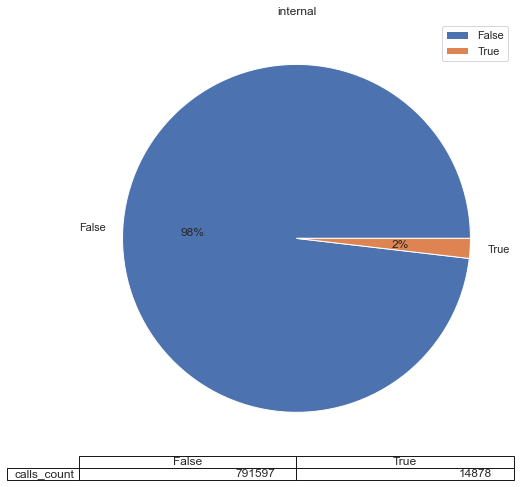

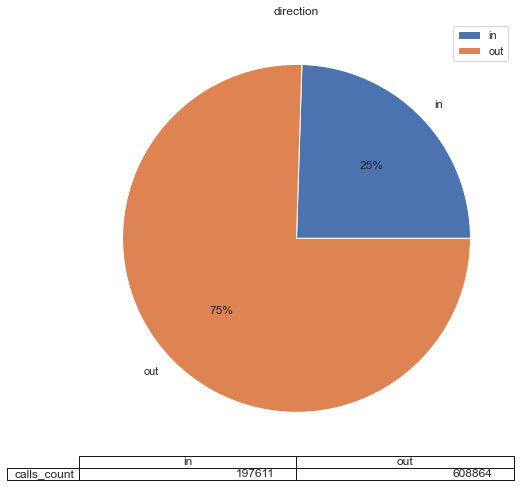

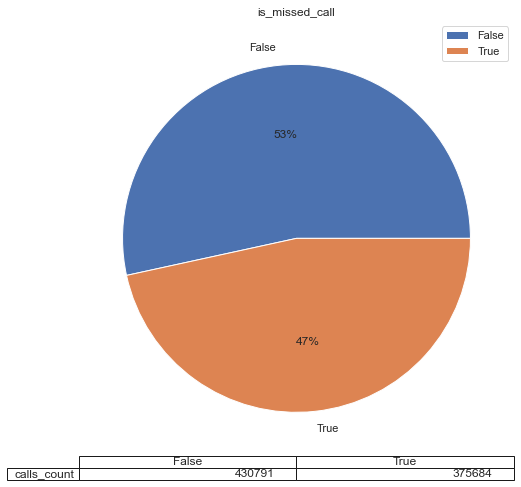

In [26]:
sns.set_theme(style="whitegrid")
for column in ['internal', 'direction', 'is_missed_call']:
    pie_chart(df, column)


Внутренние вызовы составляют 2% от общего количества. 75% приходится на исхоящие вызовы. 47% вызовов остаются неотвеченными. Рассмотрим показатели по внутренним и внешним вызовам в зависимости от направления

Рассмотрим данные о пропущенных вызовах

In [27]:
df.query('is_missed_call == True').groupby(['operator_id', 'date']).sum().describe()

,user_id,internal,is_missed_call,calls_count,call_duration,total_call_duration
count,12321.000000,12321.000000,12321.000000,12321.000000,12321.000000,12321.000000
mean,191610.205665,0.195844,1.145199,22.102021,1.928496,512.040419
std,61537.081710,0.398091,0.367869,80.539010,23.625580,1643.333198
min,166377.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,166839.000000,0.000000,1.000000,2.000000,0.000000,34.000000
50%,167497.000000,0.000000,1.000000,6.000000,0.000000,120.000000
75%,168187.000000,0.000000,1.000000,18.000000,0.000000,405.000000
max,672364.000000,2.000000,4.000000,4817.000000,741.000000,45312.000000


Заменим тип данных в столбце `is_missed_call`, где длительность разговора больше 0 на `False`

In [28]:
df.loc[(df['is_missed_call'] == True) & (df['call_duration'] > 0), 'is_missed_call'] = False

По числовым значениям длительности вызовов можно сделать вывод, что длительность вызова учитывается в секундах. Для удобства расчетов, переведем значения в минуты

In [29]:
df['total_call_duration'] = np.ceil(df['total_call_duration'] / 60)

df['call_duration'] = np.ceil(df['call_duration'] / 60)


In [30]:
(df
 .groupby(['internal','direction'])
 .agg(clients = ('user_id','nunique'),
      operators = ('operator_id','nunique'), 
      calls_count = ('calls_count','sum'),
      call_duration = ('call_duration','sum'), 
      total_call_duration = ('total_call_duration','sum'))
 
 # далее по этим данным мы можем подсчитать общую долю по клиентам:
 .assign(client_share = lambda x: x['clients'] / df['user_id'].nunique(),
        
 #подсчитаем количество звонков на одного клиента:        
         call_by_client = lambda x: x['calls_count'] / x['clients'])
)

clients  operators  calls_count  call_duration  \
internal direction                                                   
False    in             290        738       195773       169262.0   
         out            220        833       595824       540881.0   
True     in             106        179         1838         1217.0   
         out            148        503        13040        10289.0   

                    total_call_duration  client_share  call_by_client  
internal direction                                                     
False    in                    214469.0      1.000000      675.079310  
         out                   740310.0      0.758621     2708.290909  
True     in                      1863.0      0.365517       17.339623  
         out                    13091.0      0.510345       88.108108

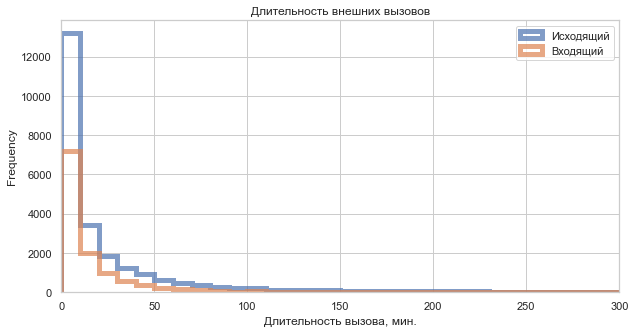

In [31]:
bin_size = 10
ax=df.query(
        'internal == False & direction == "out"'
    ).plot(
        kind='hist', 
        y='total_call_duration', 
        histtype='step',
        bins=np.arange(0, df.query(
        'internal == False & direction == "out"').total_call_duration.max(), bin_size),
        linewidth=5,
        alpha=0.7,
        label='Исходящий', 
        title='Длительность внешних вызовов',
    figsize=(10,5)
    )
plt.xlim(0, 300)
    
ax2=df.query(
        'internal == False & direction == "in" & is_missed_call== False'
    ).plot(
        kind='hist', 
        y='total_call_duration', 
        histtype='step',
        bins=np.arange(0, df.query(
        'internal == False & direction == "in" & is_missed_call== False').total_call_duration.max(), bin_size),
        linewidth=5,
        alpha=0.7,
        label='Входящий',  
        ax=ax
    )

plt.xlabel('Длительность вызова, мин.')

plt.show()


Из полученных данных можно селать вывод, что все клиенты принимают входящие внешние вызовы, а исходящие совершают только 75%, значит есть клиенты, которые работают только на входящие вызовы. В среднем клиент совершает 2000 исходящих внешних вызовов и принимает 650 входящих. Внутренние вызовы совершают только 36%, а принимают 50% клиентов. Чаще всего внешний вызов длится не более 10 минут

Проверим аномалии в данных по операторам в целом за день

In [32]:
# общие показатели операторов по дням

operator_by_day = df.groupby(['user_id', 'operator_id', 'date']).sum()
operator_by_day.describe()

,internal,is_missed_call,calls_count,call_duration,total_call_duration
count,19647.000000,19647.000000,19647.000000,19647.000000,19647.000000
mean,0.274088,0.703110,35.738026,36.305390,47.639691
std,0.578600,0.613369,114.219206,98.416172,132.953323
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,3.000000,4.000000
50%,0.000000,1.000000,9.000000,12.000000,16.000000
75%,0.000000,1.000000,32.000000,38.000000,50.000000
max,3.000000,3.000000,5022.000000,2418.000000,3168.000000


75% операторов совершают до 32 звонков в день общей продолжительностью до 50 минут. Рассмотрим клиентов с неправдоподобными значениями длительности разговора

In [33]:
operator_by_day.query('call_duration > 1000').groupby(['user_id', 'operator_id']).mean()

internal  is_missed_call  calls_count  call_duration  \
user_id operator_id                                                         
166582  885876.0     0.030303        1.242424  1291.393939    1628.060606   
        885890.0     0.000000        1.375000  1072.375000    1079.625000   
        925922.0     0.000000        1.000000  1086.000000    1051.500000   

                     total_call_duration  
user_id operator_id                       
166582  885876.0             2117.090909  
        885890.0             1516.437500  
        925922.0             1435.500000

Удалим из таблицы вызовы данного клиента

In [34]:
df = df.query('user_id != 166582')

In [35]:
df.query('calls_count > 1000').groupby('is_missed_call')['user_id'].nunique()

is_missed_call
True    5
Name: user_id, dtype: int64

Аномальные значения столбца `calls_count` относятся к пропущенным вызовам, вероятно, осуществляемых с помощью автодозвона.

Рассмотрим как распределены вызовы по времени

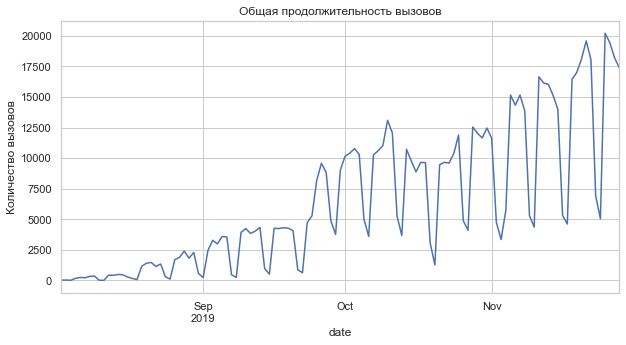

In [36]:
df.groupby('date')['total_call_duration'].sum().plot(
    kind='line', 
    grid=True, 
    title='Общая продолжительность вызовов', 
    figsize=(10, 5))
plt.ylabel('Количество вызовов')
plt.show()

График показывает, что данные включают вызовы с начала работы телефонии, а также видна цикличность в работе центра. Рассмотрим зависимость количества вызовов от дня недели

In [37]:
# добавим столбец с номером дня недели
df['day'] = df['date'].dt.weekday

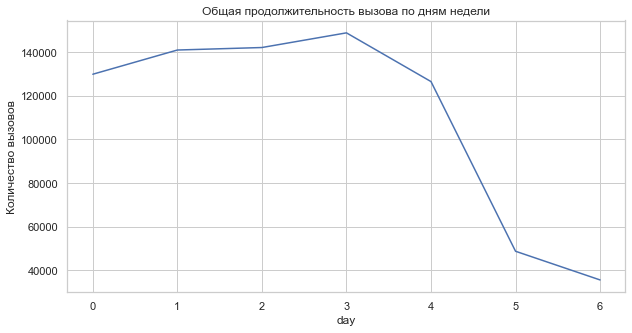

In [38]:
df.groupby('day')['total_call_duration'].sum().plot(
    kind='line', 
    grid=True, 
    title='Общая продолжительность вызова по дням недели',
    figsize=(10, 5))
plt.ylabel('Количество вызовов')

plt.show()

Вызовы совершаются в основном по будням. К пятнице их количество заметно снижается, а в выходные работает лишь малая часть клиентов. Рассмотрим продолжительность вызовов в разрезе тарифов

In [39]:
# объединяем таблицы с вызовами и данными клиентов
df = df.merge(clients, on='user_id', how='left')
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day,tariff_plan,date_start
0,166377,2019-08-04,in,False,NaN,True,2,0.0,1.0,6,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0.0,1.0,0,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0.0,1.0,0,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,1.0,1.0,0,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0.0,1.0,0,B,2019-08-01


In [40]:
# функция для визуализации
def calls_visualisation(data, time, column, func):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot(2, 2, 1)
    data.pivot_table(index=time,
                     columns=column,
                     values='user_id',
                     aggfunc='nunique').plot(kind='line',
                                             grid=True,ax=ax1)
    plt.legend()
    plt.title('Количество клиентов')

    ax2 = plt.subplot(2, 2, 2)
    data.pivot_table(index=time,
                     columns=column,
                     values='calls_count',
                     aggfunc=func).plot(kind='line', 
                                        grid=True, 
                                        ax=ax2)

    plt.legend()
    
    if func == 'sum':
        title = 'Общее количество вызовов'
    elif func == 'mean':
        title = 'Среднее количество вызовов'
    else: title = 'Количество вызовов'
    plt.title(title)

    ax3 = plt.subplot(2, 2, 3)
    data.pivot_table(index=time,
                     columns=column, 
                     values='call_duration',
                     aggfunc=func).plot(kind='line',
                                        grid=True,
                                        ax=ax3)

    plt.legend()
    
    if func == 'sum':
        title = 'Общая продолжительность разговора'
    elif func == 'mean':
        title = 'Средняя продолжительность разговора'
    else: title = 'Продолжительность разговора'
 
    plt.title(title)
    
    ax4 = plt.subplot(2, 2, 4)
    data.pivot_table(index=time,
                     columns=column, 
                     values='total_call_duration',
                     aggfunc=func).plot(kind='line', 
                                        grid=True,
                                        ax=ax4)

    plt.legend()
    
    if func == 'sum':
        title = 'Общая продолжительность вызова'
    elif func == 'mean':
        title = 'Средняя продолжительность вызова'
    else: title = 'Продолжительность вызова'
    plt.title(title)


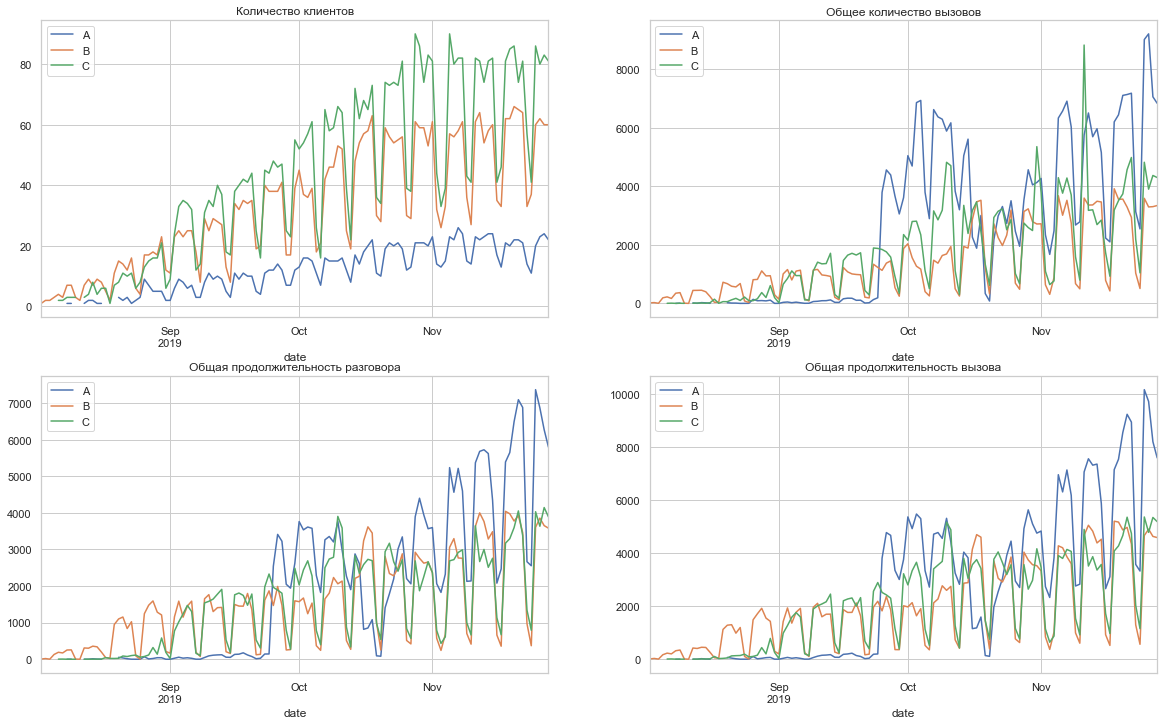

In [41]:
calls_visualisation(df, 'date', 'tariff_plan', 'sum')

По графикам можно сделать вывод, что в августе работали в основном клиенты на тарифе В, в сентябре подключились клиенты тарифа С, а данные по тарифу А есть только с конца сентября. Основная часть клиентов использует тариф С с наименьшей абонентской платой, второй по популярности тариф В. С середины октября не наблюдается значительного роста количества клиентов на всех тарифах, а на тарифе А заметно резкое снижение активности клиентов во второй половине октября. Для сравнительного анализа тарифов оставим в работе период, когда на каждом сформировалась достаточная клиентская база

In [42]:
df = df.query('date >= "2019-10-01"')

### Анализ клиентов

Исключим из данных неактивных клиентов. Будем считать активными тех клиентов, кто зарегистрирован меньше 30 дней с последней даты имеющихся вызовов, а неактивными тех, кто зарегистрирован давно, но не совершал звонков в течение последних 30 дней

In [43]:
ACTIVE_DAYS = 30

In [44]:
# таблица с датой регистрации и датой последнего вызова для каждого клиента
activity = df.groupby('user_id').agg({'date_start': 'max', 'date': 'max'}).reset_index()

In [45]:
# добавим столбцы с количеством дней регистрации и дней с даты последнего вызова
activity['registered'] = (LAST_DATE - activity['date_start']).dt.days
activity['last_call'] = (LAST_DATE - activity['date']).dt.days

In [46]:
# функция для определения активности клиента
def active_users(row_values):
    if row_values['registered'] < ACTIVE_DAYS:
        return True
    elif row_values['last_call'] < ACTIVE_DAYS:
        return True
    return False

In [47]:
# добавим колонку с информацией об активности
activity['active_user'] = activity.apply(active_users, axis=1)

# выделяем список неактивных клиентов
not_active_users = activity[activity['active_user'] == False]['user_id']

# исключаем из таблицы с вызовами строки с неактивными клиентами
df = df.query('user_id not in @not_active_users')

print('Активных клиентов:',df['user_id'].nunique())

Активных клиентов: 256


In [48]:
operators = df.groupby(['user_id', 'tariff_plan'])['operator_id'].nunique().reset_index()

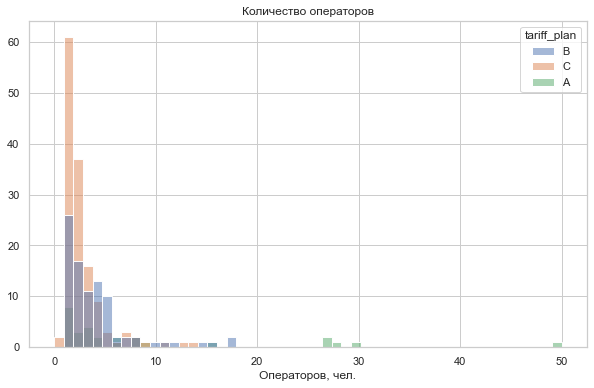

In [49]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))  
sns.histplot(data=operators, x="operator_id", hue='tariff_plan')
plt.title('Количество операторов')
plt.xlabel('Операторов, чел.')
plt.ylabel(None)
plt.show()

Больше всего операторов у клиентов на тарифе В и С. Для абонентов тарифа С характерна работа 1-2 операторов, а у абонентов тарифа В работают о 5 операторов.

### Анализ вызовов

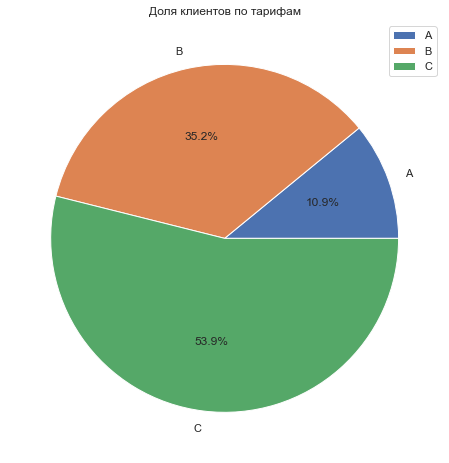

In [50]:
df.groupby('tariff_plan').agg({'user_id': 'nunique'}).plot(
    kind='pie', 
    y='user_id', 
    autopct='%1.1f%%',
    title='Доля клиентов по тарифам', 
    figsize=(8, 8))
plt.ylabel(None)
plt.show()


In [51]:
df.groupby('tariff_plan').agg({'user_id': 'nunique'})

,user_id
tariff_plan,
A,28
B,90
C,138


Чуть больше половины клиентов используют тариф С, второй по популярности тариф В, а клиенты тарифа А составляют лишь 10,9%.

Рассмотрим средние показатели продолжительности и количества вызовов

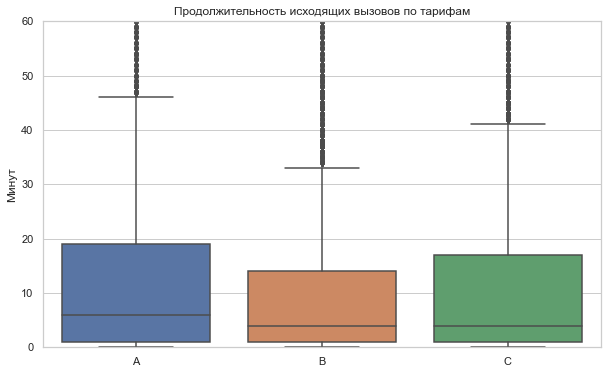

In [52]:
plt.figure(figsize=(10, 6))  
sns.boxplot(x ='tariff_plan',y = 'total_call_duration', data = df.query('direction == "out"').sort_values(by='tariff_plan'))
plt.ylim(0, 60)
plt.title('Продолжительность исходящих вызовов по тарифам')
plt.ylabel('Минут')
plt.xlabel(None)
plt.show()

Медиана близка для всех тарифов на отметке около 5 минут. Для тарифа А 75% вызовов заканчиваются до 20 минут, чуть меньше на тарифе С, а для тарифа В около 15 минут.

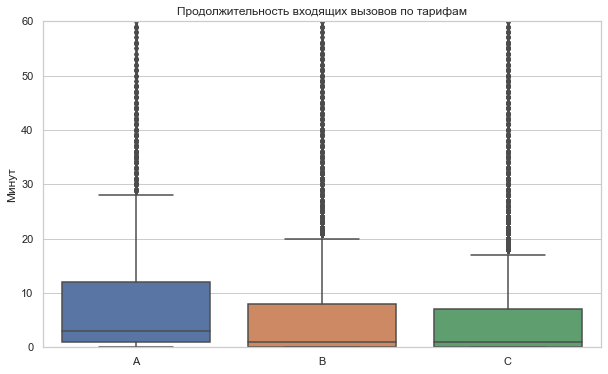

In [53]:
plt.figure(figsize=(10, 6))  
sns.boxplot(x ='tariff_plan',y = 'call_duration', data = df.query('direction == "in"').sort_values(by='tariff_plan'))
plt.title('Продолжительность входящих вызовов по тарифам')
plt.ylim(0, 60)
plt.ylabel('Минут')
plt.xlabel(None)
plt.show()

Входящие вызовы заметно короче на всех тарифах. Для тарифа А и В характерны звонки длительностью до 5 минут, а на тарифе а до 10 минут. Как для входящих, так и для исходящих вызовов есть большое количество выбросов с нехарактерной длительностью. Проверим, есть ли абоненты, которые работают только с входящими либо только с исходящими звонками

<div class="alert alert-warning">
<b>Комментарий тимлида v.1</b> 
    
📝 С одной стороны, все верно, что ты смотришь на динамику значений, которые мы будем использовать в расчетах. Но тут тоже есть момент агрегированных данных. Лучше, когда мы сравниваем или длительность или количество нормировать на что-то. Если бы у нас каждая строка содержала информацию только о одном звонке - тогда вопросов не было бы.
    </div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Комментарий студента v.2</b>
Меняем</div>

<div class="alert alert-success">
<b>Комментарий тимлида v.2</b> 
    
👍
</div>

In [54]:
user_by_day = df.groupby(['user_id', 'tariff_plan', 'date', 'direction']).sum().reset_index()

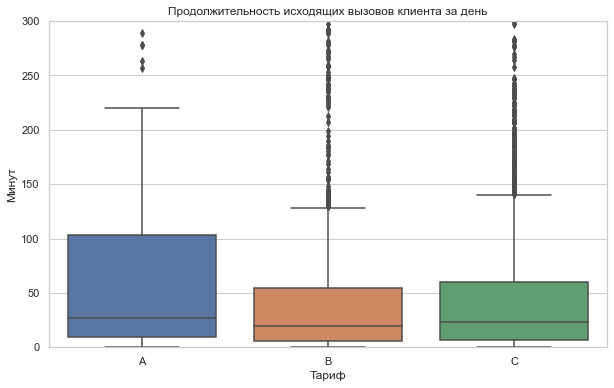

In [55]:
plt.figure(figsize=(10, 6))  
sns.boxplot(x ='tariff_plan',y = 'total_call_duration', data = user_by_day.query('direction == "out"').sort_values(by='tariff_plan'))
plt.ylim(0, 300)
plt.title('Продолжительность исходящих вызовов клиента за день')
plt.ylabel('Минут')
plt.xlabel('Тариф')
plt.show()

Клиенты тарифа А чаще всего тратят до 100 минут на исходящие вызовы в день, тарифа С и В - около 50 минут.

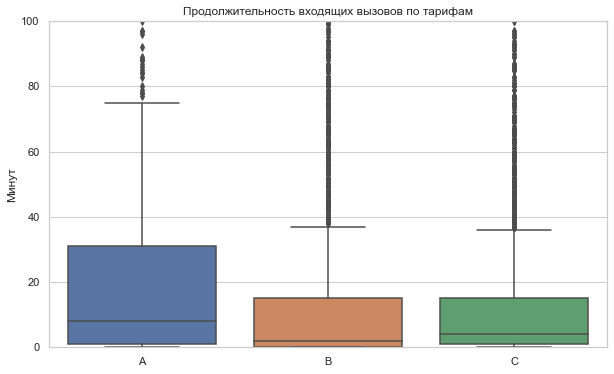

In [56]:
plt.figure(figsize=(10, 6))  
sns.boxplot(x ='tariff_plan',y = 'call_duration', data = user_by_day.query('direction == "in"').sort_values(by='tariff_plan'))
plt.title('Продолжительность входящих вызовов по тарифам')
plt.ylim(0, 100)
plt.ylabel('Минут')
plt.xlabel(None)
plt.show()

На входящие вызовы клиенты тарифа А трятят в основном до 30 минут, а клиентам тарифов В и С достаточно 20 минут

In [57]:
# столбец с номером месяца
df['month'] = df['date'].dt.month

In [58]:
# список клиентов с единственным направлением внешних вызовов
users_one_direction = df.query('internal == False').groupby('user_id').nunique().query('direction == 1').index
df.query('user_id in @users_one_direction').groupby('direction')['user_id'].nunique()

direction
in     66
out     1
Name: user_id, dtype: int64

In [59]:
df.query('user_id in @users_one_direction').groupby(
    ['tariff_plan', 'month']
).agg(
    {'user_id':'nunique', 'is_missed_call': 'sum', 'operator_id': 'nunique', 'total_call_duration': 'sum'}
)

user_id  is_missed_call  operator_id  total_call_duration
tariff_plan month                                                           
A           10           4              74            9                747.0
            11           5              63            8                647.0
B           10          13              93           20                556.0
            11          15             155           21               2697.0
C           10          43             253           51               2301.0
            11          44             235           60               2985.0

Всего 63 клиента только принимают входяще вызовы, основная часть которых использует тариф С с наименьшей абонентской платой

### Вывод

В результате анализа данных были исключены неактивные клиенты, которые зарегистрированы давно, но в последнее время не совершали вызовы. Всего активных клиентов 256. Среди них чаще всего встречаются клиенты тарифа С и реже тарифа А. Редко число операторов превышает 5 человек, чаще всего встречаются клиенты с одним оператором. Для тарифа А характерны продолжительные вызовы. 63 клиента работают только на входящих вызовах

## Выручка

### Фактическая выручка

In [60]:
# таблица с общим количеством исходящих внешних вызовов

total_out_calls = df.query(
    'direction == "out"'
).groupby(['user_id', 'tariff_plan', 'month', 'internal']
).agg(
    {
        'total_call_duration': 'sum'
    }
).reset_index()
total_out_calls.head()


,user_id,tariff_plan,month,internal,total_call_duration
0,166377,B,10,False,1704.0
1,166377,B,10,True,2.0
2,166377,B,11,False,1633.0
3,166377,B,11,True,4.0
4,166405,B,10,False,6390.0


In [61]:
# таблица с общим количеством входящих внешних вызовов

total_In_calls = df.query(
    'direction == "in"'
).groupby(['user_id', 'tariff_plan', 'month', 'internal']
).agg(
    {
        'total_call_duration': 'sum'
    }
).reset_index()
total_In_calls.head()

,user_id,tariff_plan,month,internal,total_call_duration
0,166377,B,10,False,60.0
1,166377,B,11,False,66.0
2,166391,C,10,False,2.0
3,166391,C,11,False,4.0
4,166392,C,10,False,145.0


Так как входящие вызовы не тарифицируются, обнулим значение столбца `total_call_duration`

In [62]:
total_In_calls['total_call_duration'] = 0

# получаем таблицу с общим количеством звонков
total_calls = total_In_calls.append(total_out_calls)

In [63]:
# добавляем условия тарифа
income = total_calls.merge(tariffs, on='tariff_plan', how='left')
income.head()

,user_id,tariff_plan,month,internal,total_call_duration,rub_monthly_fee,minutes_included,rub_per_min_in,rub_per_min_out,rub_per_operator
0,166377,B,10,False,0.0,2000,2000,0.15,0.5,100
1,166377,B,11,False,0.0,2000,2000,0.15,0.5,100
2,166391,C,10,False,0.0,1000,2000,0.30,0.7,100
3,166391,C,11,False,0.0,1000,2000,0.30,0.7,100
4,166392,C,10,False,0.0,1000,2000,0.30,0.7,100


Проверим максимальное количество минут внутренних вызовов в месяц

In [64]:
income.query('internal == True').groupby('month')['total_call_duration'].max()

month
10     486.0
11    1540.0
Name: total_call_duration, dtype: float64

Ни один клиент не израсходовал пакет минут внутренних вызовов, а значит внутренние вызовы клиенты не оплачивали

In [65]:
# функция для подсчета выручки по каждому типу вызова

def tariff_calls(row):
    if row['internal'] == False:
        month_income = row['total_call_duration'] * row['rub_per_min_out']
        return round(month_income)
    if row['total_call_duration'] >= row['minutes_included']:
        month_income = (row['total_call_duration'] - (row['minutes_included'] - 1)) * row['rub_per_min_in']
        return round(month_income)
    month_income = 0
    return round(month_income)

In [66]:
# функция для подсчета общей выручки за месяц

def income_by_month(income_df, raw_df):
    income_df['calls'] = income_df.apply(tariff_calls, axis=1) 
    operator_count = raw_df.groupby(['user_id', 'month'])['operator_id'].nunique().reset_index()
    income_by_month = income_df.groupby(
        [
            'user_id', 'month', 'tariff_plan'
        ]
    ).agg(
        {
            'rub_monthly_fee': 'first', 'rub_per_operator': 'first', 'calls': 'sum'
        }
    ).reset_index()
    income_by_month = income_by_month.merge(operator_count, on=['user_id', 'month'], how='right')
    income_by_month['operator_id'] = income_by_month['operator_id'] * income_by_month['rub_per_operator']
    income_by_month['total'] = income_by_month['operator_id'] + income_by_month['rub_monthly_fee'] + income_by_month['calls']
    income_by_month = income_by_month.rename(columns={'operator_id': 'operator'})
    return income_by_month

In [67]:
income_fact = income_by_month(income, df)
income_fact.head()

,user_id,month,tariff_plan,rub_monthly_fee,rub_per_operator,calls,operator,total
0,166377,10,B,2000,100,852,500,3352
1,166377,11,B,2000,100,816,400,3216
2,166391,10,C,1000,100,0,0,1000
3,166391,11,C,1000,100,0,100,1100
4,166392,10,C,1000,100,0,200,1200


### Визуализация фактической выручки

In [68]:
# функция для визуализации выручки

def income_vis(income_df):
    income_df.pivot_table(index='month',
                     columns='tariff_plan',
                     values='total',
                     aggfunc='mean',
                  ).plot(kind='line',
                         figsize=(10,5),
                         grid=True)
    plt.show()
    report = income_df.groupby('tariff_plan').sum()
    total_income = report['total'].sum()
    print('Выручка всего:', total_income)
    
    report.plot(kind='pie', y='total', autopct='%1.1f%%',title='Доля выручки по тарифам', figsize=(8, 8))
    plt.ylabel(None)
    plt.show()
    
    g = sns.catplot(
        data=income_df.sort_values(by='tariff_plan'), kind="bar",
        x="month", y='total', hue='tariff_plan',
        ci="sd", palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("", "Выручка, руб.")
    g.legend.set_title("")
    
    report = report[['rub_monthly_fee', 'calls', 'operator']].T
    for column in report.columns:
        report.plot(kind='pie', y=column, autopct='%1.1f%%',title=column, figsize=(8, 8))
        plt.show()

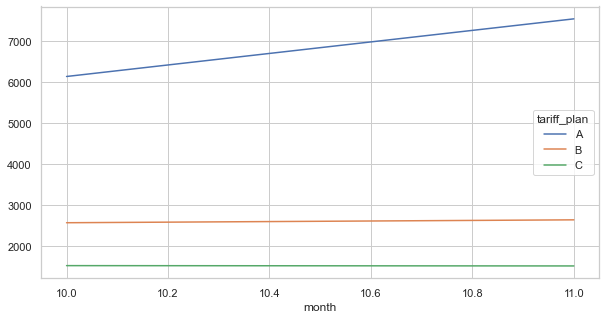

Выручка всего: 1216802


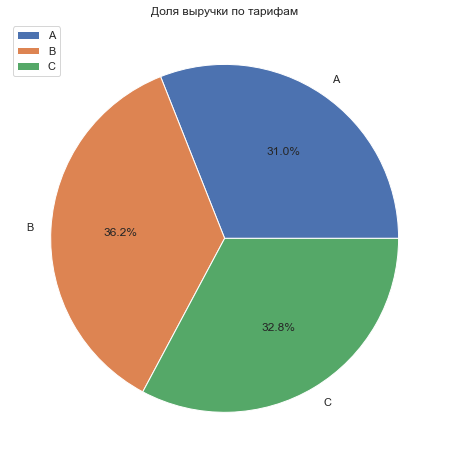

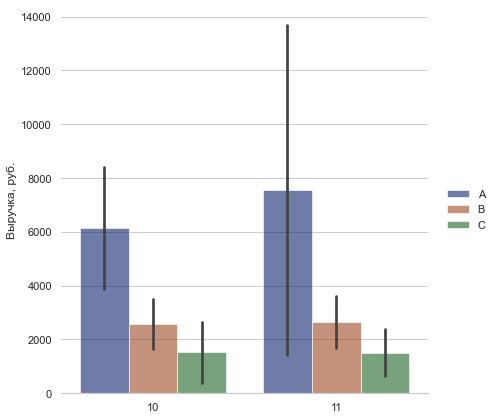

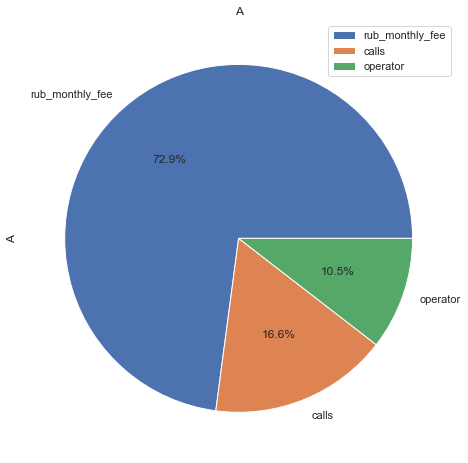

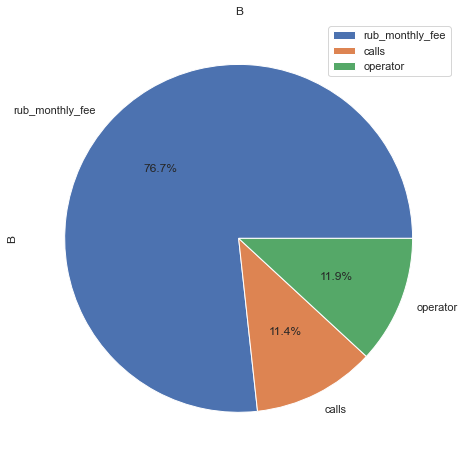

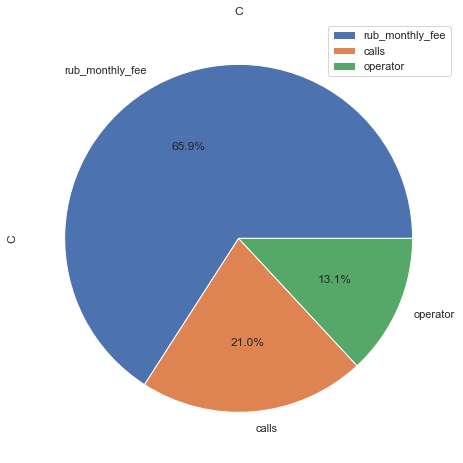

In [69]:
income_vis(income_fact)

По графикам можно сделать вывод что выручка тарифа А увеличивалась на протяжении всего периода наблюдений, выручка остальных тарифов заметно не изменялась. Не смотря на существенную разницу в количестве клиентов, все три тарифа принесли примерно одинаковый доход. Основную часть выручки составляет абонентская плата

### Поиск клиентов с неоптимальными тарифами

Для поиска клиентов с невыгодным тарифом, сравним тариф вычислим при каком количестве минут исходящих внешних вызовов абонентска плата будет одинакова и предложим клиентам более выгодный тариф, если он расходует меньше этого количества

In [70]:
A_B = int((5000 - 2000) / (0.5 - 0.4))
A_B

30000

In [71]:
B_C = int((2000 - 1000) / (0.7 - 0.5))
B_C

5000

Целесобразно перейти на тариф В тем клиентам тарифа А, которые расходуют менее 30000. Тем абонентам тарифа В, которые расходуют до 5000 минут целесобразно сменить тариф на С.

In [72]:
# исходящие внешние вызовы 

total_out_calls_ext = total_out_calls.query('internal == False')
total_out_calls_ext.head()

,user_id,tariff_plan,month,internal,total_call_duration
0,166377,B,10,False,1704.0
2,166377,B,11,False,1633.0
4,166405,B,10,False,6390.0
6,166405,B,11,False,6888.0
8,166406,B,10,False,1886.0


In [73]:
# функция возвращает подходящий тариф или запись "Оптимальный тариф", если клиент не переплачивает

def offer(row):
    if row['tariff_plan'] == "A":
        if row['total_call_duration'] > 30000:
            return 'Оптимальный тариф'
        #if row['total_call_duration'] <= 30000 #and row['total_call_duration'] > 5000:
        return 'B'
        #return 'C'
    if row['tariff_plan'] == "B":
        if row['total_call_duration'] > 30000:
            return 'A'
        if row['total_call_duration'] <= 30000 and row['total_call_duration'] > 5000:
            return 'Оптимальный тариф'
        return 'C'
    if row['tariff_plan'] == "C":
        if row['total_call_duration'] > 30000:
            return 'A'
        if row['total_call_duration'] <= 30000 and row['total_call_duration'] > 5000:
            return 'B'
        return 'Оптимальный тариф'

In [74]:
# добавляем столбец с оптимальным тарифом
total_out_calls_ext['offer'] = total_out_calls_ext.apply(offer, axis=1)
# список "клиент - новый тариф".
change_tariff = total_out_calls_ext.groupby('user_id').agg(
fact_tariff = ('tariff_plan', 'last'),
offer = ('offer', 'last')
).query('offer != "Оптимальный тариф"').reset_index()

In [75]:
temp = income_fact.query('calls == 0 & tariff_plan == "A"').groupby(['user_id', 'tariff_plan']).sum().reset_index()
temp['offer'] = 'B'
temp = temp[['user_id', 'tariff_plan', 'offer']]
temp = temp.rename(columns = {'tariff_plan': 'fact_tariff'})

In [76]:
change_tariff = change_tariff.append(temp)

### Выручка с учетом смены тарифа

In [77]:
income_copy = income.copy()

In [78]:
def changed_income(income_copy, change_tariff):
    # столбец с новым тарифом
    income_copy = income_copy.merge(change_tariff, on='user_id', how='left')
    # цикл возвращает первоначальный тариф для тех клиентов, кому смента тарифа не требуется

    for tariff in tariffs['tariff_plan'].unique():
        income_copy.loc[(income_copy['offer'].isna()) & (income_copy['tariff_plan'] == tariff), 'offer'] = tariff
        
    # удаляем столбец с первоначальным тарифом

    income_copy = income_copy.drop('tariff_plan', axis=1)
    income_copy = income_copy.rename(columns={'offer': 'tariff_plan'})
    income_copy = income_copy[['user_id', 'month', 'internal', 'total_call_duration', 'tariff_plan']]
    return income_copy

In [79]:
income_copy = changed_income(income_copy, change_tariff)

In [80]:
income_new = income_copy.merge(tariffs, on='tariff_plan', how='left')
income_new.head()

,user_id,month,internal,total_call_duration,tariff_plan,rub_monthly_fee,minutes_included,rub_per_min_in,rub_per_min_out,rub_per_operator
0,166377,10,False,0.0,C,1000,2000,0.3,0.7,100
1,166377,11,False,0.0,C,1000,2000,0.3,0.7,100
2,166391,10,False,0.0,C,1000,2000,0.3,0.7,100
3,166391,11,False,0.0,C,1000,2000,0.3,0.7,100
4,166392,10,False,0.0,C,1000,2000,0.3,0.7,100


In [81]:
# рассчитываем выручку с учетом смены тарифа

income_new_tariff = income_by_month(income_new, df)

In [82]:
# оставляем итоговые суммы с учeтом смены тарифа
comparing = income_new_tariff.copy()

In [83]:
comparing = comparing[['user_id', 'month', 'tariff_plan', 'total']]
comparing.head()

,user_id,month,tariff_plan,total
0,166377,10,C,2693
1,166377,11,C,2543
2,166391,10,C,1000
3,166391,11,C,1100
4,166392,10,C,1200


In [84]:
comparing = comparing.rename(columns = {'tariff_plan': 'tariff_plan_new', 'total': 'total_new'})
comparing.head()

,user_id,month,tariff_plan_new,total_new
0,166377,10,C,2693
1,166377,11,C,2543
2,166391,10,C,1000
3,166391,11,C,1100
4,166392,10,C,1200


In [85]:
#  создаем таблицу с фактической и выручкой с учетом изменений и добавляем столбец с переплатой
two_tariffs = income_fact.merge(comparing, on=['user_id', 'month'], how='left')
two_tariffs['over'] = two_tariffs['total'] - two_tariffs['total_new']
two_tariffs.query('over > 0').describe()

,user_id,month,rub_monthly_fee,rub_per_operator,calls,operator,total,total_new,over
count,192.000000,192.000000,192.000000,192.0,192.000000,192.000000,192.000000,192.000000,192.000000
mean,167399.453125,10.515625,2796.875000,100.0,380.619792,399.479167,3576.973958,2133.864583,1443.109375
std,591.280382,0.501062,1351.900204,0.0,1039.842666,554.420352,1940.609305,1516.539431,908.150006
min,166377.000000,10.000000,1000.000000,100.0,0.000000,0.000000,2000.000000,1000.000000,182.000000
25%,166898.250000,10.000000,2000.000000,100.0,6.000000,100.000000,2252.000000,1294.000000,925.750000
50%,167348.500000,11.000000,2000.000000,100.0,62.000000,300.000000,2603.500000,1707.500000,992.000000
75%,167977.000000,11.000000,5000.000000,100.0,264.500000,400.000000,5100.250000,2408.000000,2609.000000
max,168603.000000,11.000000,5000.000000,100.0,8462.000000,4600.000000,13654.000000,11667.000000,3000.000000


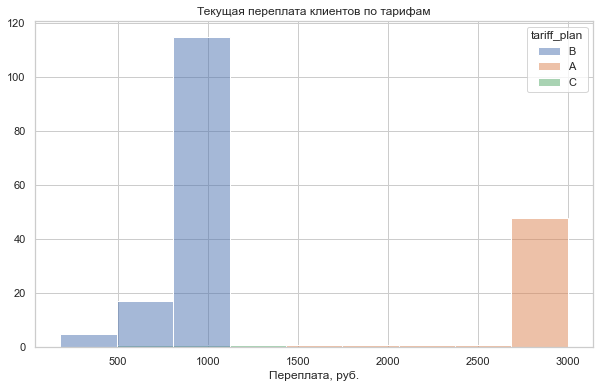

In [86]:
plt.figure(figsize=(10, 6))  
sns.histplot(data=two_tariffs.query('over > 0'), x="over", hue='tariff_plan')
plt.xlabel('Переплата, руб.')
plt.ylabel(None)
plt.title('Текущая переплата клиентов по тарифам')
plt.show()

Большинство клиентов с невыгодным тарифом переплачивали около 1000 в месяц. На тарифе С таких клиентов мало, а самая большая переплата у клиентов тарифа А. По сути, переплата определяется разницей в абонентской плате.

### Визуализация выручки с учетом изменений

In [87]:
income_fact.groupby('tariff_plan')['user_id'].nunique()

tariff_plan
A     28
B     90
C    138
Name: user_id, dtype: int64

In [88]:
income_new_tariff.groupby('tariff_plan')['user_id'].nunique()

tariff_plan
A      1
B     46
C    209
Name: user_id, dtype: int64

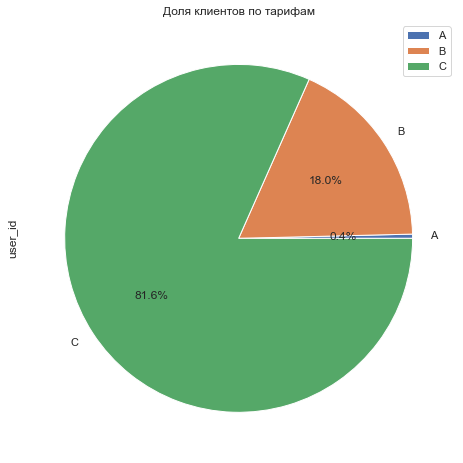

In [89]:
income_new_tariff.groupby('tariff_plan').agg({'user_id': 'nunique'}).plot(
    kind='pie', 
    y='user_id', 
    autopct='%1.1f%%',
    title='Доля клиентов по тарифам', 
    figsize=(8, 8))
plt.show()

После смены тарифа можно сделать вывод, что для текущих клиентов самым выгодням является тариф С, значит среди клиентов мало тех, кто расходует больше количество минут

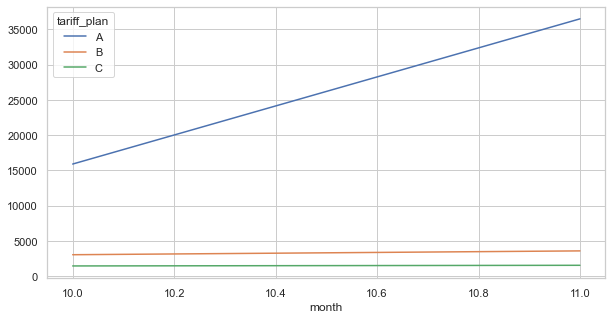

Выручка всего: 946827


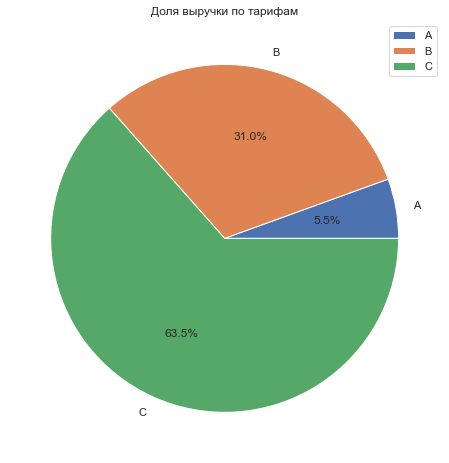

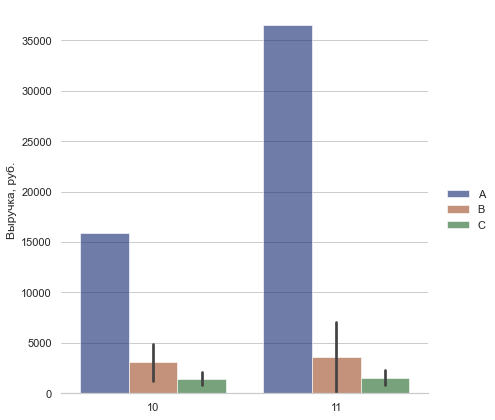

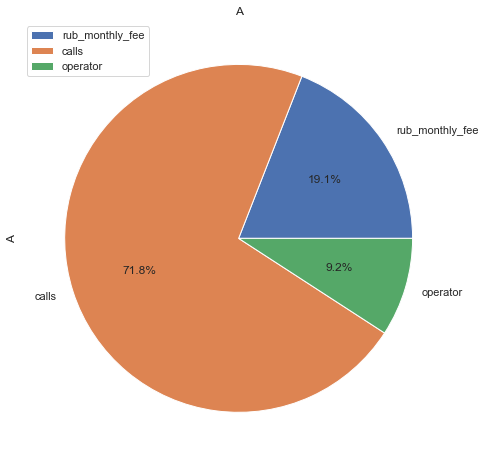

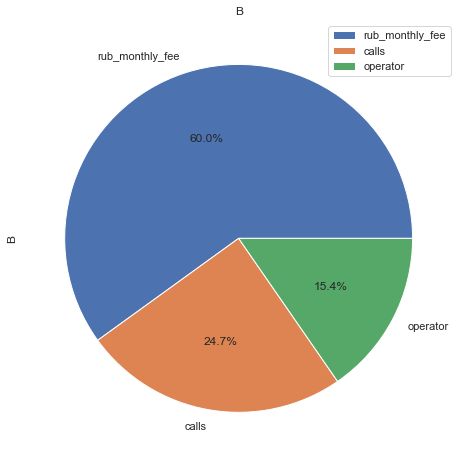

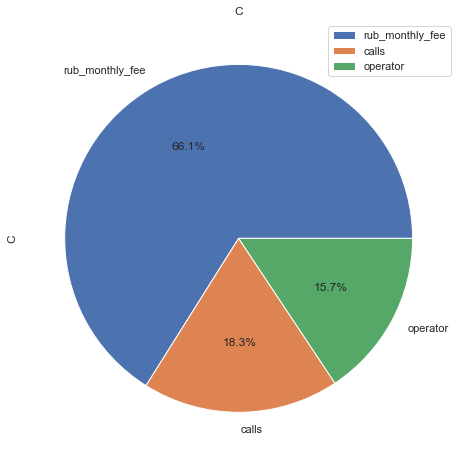

In [90]:
income_vis(income_new_tariff)

График среднего чека клиентов тарифа А вырос за счет большого оттока клиентов, данный тариф остался выгодным только для одного абонента. Средний чек абонентов тарифа В вырос незначительно, а тарифа С остался на прежнем уровне

Рассмотрим клиентов, оставшихся на тарифе А

In [91]:
income_new_tariff.query('tariff_plan == "A"')

,user_id,month,tariff_plan,rub_monthly_fee,rub_per_operator,calls,operator,total
456,168361,10,A,5000,100,8614,2300,15914
457,168361,11,A,5000,100,28998,2500,36498


После перехода на более выгодные тарифы, тариф А остался оптимальным только для одного абонента

### Оптимизация потерь

Поситаем потери выручки с учетом смены клиентами тарифа на более выгодный

In [92]:
print('Выручка факт:', income_fact['total'].sum())
print('Выручка после сменты тарифа:', income_new_tariff['total'].sum())
print('Потери выручки после сменты тарифа: {:.1%}'.format(
    (income_fact['total'].sum() - income_new_tariff['total'].sum()) / income_new_tariff['total'].sum()
)
)

Выручка факт: 1216802
Выручка после сменты тарифа: 946827
Потери выручки после сменты тарифа: 28.5%


Рассмотрим выручку клиентов, работающих как с входящими, так и с исходящими вызовами

In [93]:
income_fact.query('user_id not in @users_one_direction').groupby(
    ['tariff_plan', 'month']
).agg(
    {'user_id':'nunique', 'operator': 'sum', 'total': 'mean'}
)

user_id  operator        total
tariff_plan month                                
A           10          23     16800  6301.260870
            11          23     21000  8069.173913
B           10          67     22000  2649.880597
            11          74     26200  2741.216216
C           10          87     19100  1720.436782
            11          89     22000  1700.134831

Для оптимизации потерь выручки за счет перехода части клиентов на более выгодные тарифы, целесобразно увеличить абонентскую плату тарифа С на 100 р и тарифа В на 300 р.  Так, для текущих абонентов увеличение платы будет несущественным, а клиентам, перешедшим на эти тарифы выгода сохранится.

Также, для оптимизации выручки с клиентов, работающих только на входящие вызовы, следует перевести таких клиентов с тарифа С на тариф В и в дальнейшем исключить возможность для новых абонентов такого типа подключаться на тариф С.

In [94]:
tariffs_new = tariffs
tariffs_new.loc[2, 'rub_monthly_fee'] = 1100
tariffs_new.loc[1, 'rub_monthly_fee'] = 2300
tariffs_new

,tariff_plan,rub_monthly_fee,minutes_included,rub_per_min_in,rub_per_min_out,rub_per_operator
0,A,5000,2000,0.10,0.4,100
1,B,2300,2000,0.15,0.5,100
2,C,1100,2000,0.30,0.7,100


In [95]:
# список клиентов для перевода на тариф В с тарифа С

optim_users = clients.query('user_id in @users_one_direction and tariff_plan == "C"')
optim_users = optim_users[['user_id', 'tariff_plan']]
optim_users = optim_users.rename(columns={'tariff_plan': 'offer'})
optim_users['offer'] = "B"

offer_user_list = optim_users.append(change_tariff)
print('Тариф изменен повторно:', len(offer_user_list.groupby('user_id').nunique().query('offer > 1')))

Тариф изменен повторно: 0


In [96]:
# оптимизированная выручка
optim_income = changed_income(income_copy, optim_users)
optim_income = optim_income.merge(tariffs_new, on='tariff_plan', how='left')

In [97]:
optim_income.groupby('tariff_plan')['user_id'].nunique()

tariff_plan
A      1
B     92
C    163
Name: user_id, dtype: int64

In [98]:
# рассчитываем выручку с учетом смены тарифа и абонентской платы

income_optimized = income_by_month(optim_income, df)

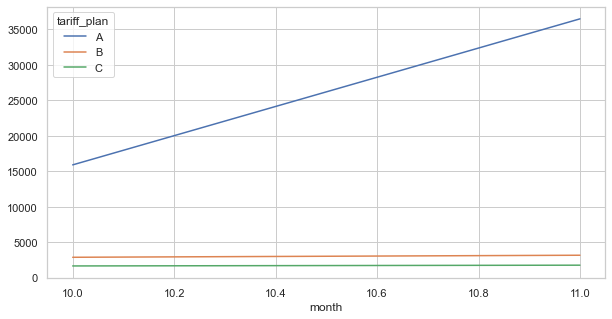

Выручка всего: 1117327


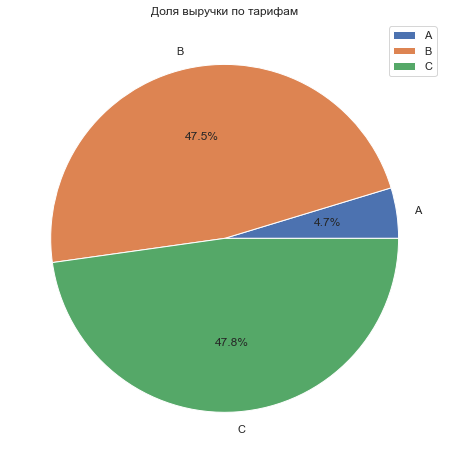

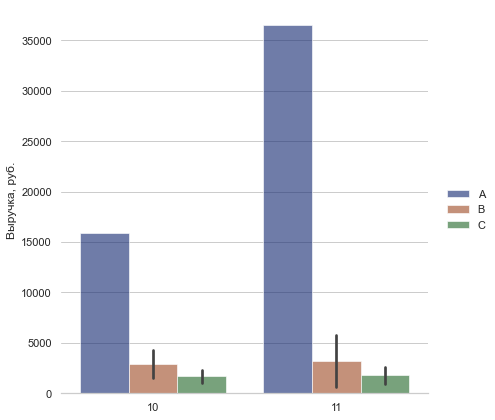

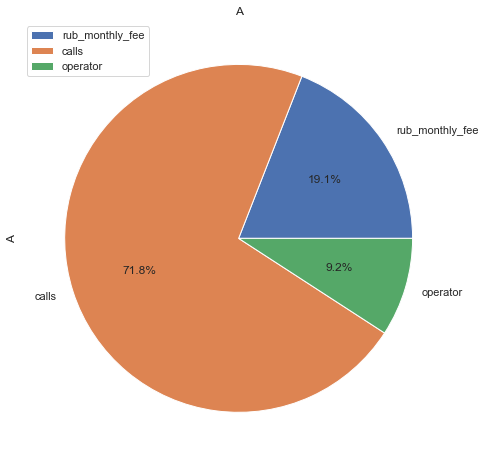

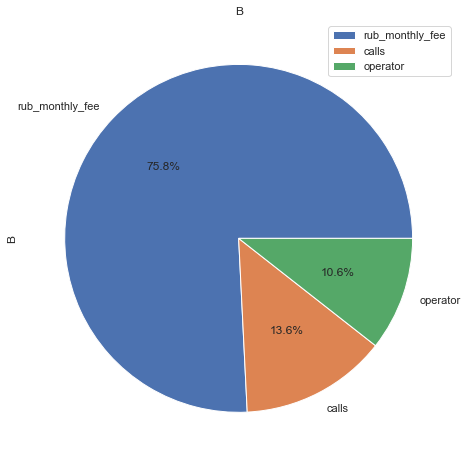

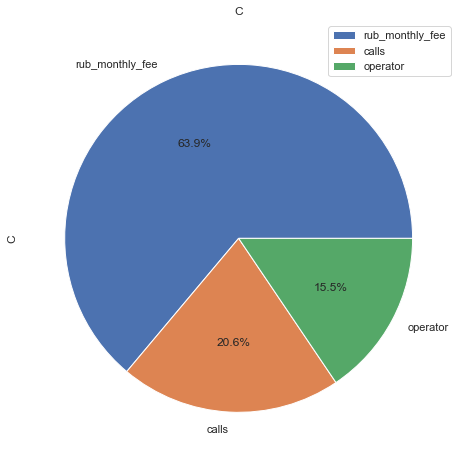

In [99]:
income_vis(income_optimized)

Посчитаем выручку после оптимизации

In [100]:
print('Выручка факт:', income_fact['total'].sum())
print('Выручка после оптимизации:', income_optimized['total'].sum())
print('Потери выручки после оптимизации: {:.1%}'.format(
    (income_fact['total'].sum() - income_optimized['total'].sum()) / income_optimized['total'].sum()
)
)

Выручка факт: 1216802
Выручка после оптимизации: 1117327
Потери выручки после оптимизации: 8.9%


###  Вывод

Фактическая выручка составляет 1 216 802 руб. Каждый тариф приносит телефонии одинаковый доход, основная часть которого приходится на абонетскую плату, а плата за исходящие внутренние вызовы составила 0 руб. По результатам исследования больше переплачивают клиенты тарифа А, но реже, чем клиенты тарифа В, для которых сумма переплаты составляет около 1000 руб. Тариф С остается выгодным практически для всех действующих абонентов. В случае перехода клиентов на более выгодные тарифы выручка снизится на 28,5%, а тариф А останется оптимальным только для одного клиента. После оптимизации потерь незначительным увеличением абонентской платы, выручка составила 1 117 327 руб., что позволило снизить потери до 8,9%

## Проверка гипотез

- средние чеки клиента до и после перехода на оптимальный тариф одинаковы
- средние чеки клиента до и после оптимизации потерь равны

Проверим гипотезу, что средняя выручка пользователей до и после перехода на оптимальный тариф различаются.
Н0-Средняя выручка тарифов равна
Н1-Средняя выручка тарифов различается

In [101]:
user_list = change_tariff['user_id']

In [102]:
before = income_fact.query('user_id in @user_list')
after = income_optimized.query('user_id in @user_list')



alpha = 0.05  # критический уровень статистической значимости
    # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(after['total'], before['total'])

print('p-значение:', results.pvalue)

print(after['total'].describe(), before['total'].describe())


if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Cредние чеки клиента до и после перехода на оптимальный тариф различаются')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    print('Cредние чеки клиента до и после перехода на оптимальный тариф равны')
    print()

p-значение: 1.2325647184852421e-08
count      193.000000
mean      2392.424870
std       2100.187679
min       1100.000000
25%       1400.000000
50%       1813.000000
75%       2658.000000
max      21836.000000
Name: total, dtype: float64 count      193.000000
mean      3633.227979
std       2087.367109
min       2000.000000
25%       2254.000000
50%       2604.000000
75%       5101.000000
max      14434.000000
Name: total, dtype: float64
Отвергаем нулевую гипотезу
Cредние чеки клиента до и после перехода на оптимальный тариф различаются



Проверка гипотезы показала, что средние чеки клиентов, перешедших на оптимальный тариф различаются. По средним значениям можно сделать вывод, что клиенты будут тратить меньше при переходе на рекомендуемый тариф

Проверим гипотезу, что средние чеки клиента до и после минимизации падения выручки одинаковы
Н0-Средняя выручка тарифов равна
Н1-Средняя выручка тарифов различается

Перед проведением теста изучим детально данные. Для t-теста подходят выборки, которые обладают нормальным распределением (или имеют более 30 наблюдений в каждой выборке), при этом нам также важно сравнить дисперсии двух выборок, от этого будет зависеть параметр `equal_var`. Поэтому, посмотрим на распределение сравниваемых значений на примере среднего чека, который был расчитан по имеющимся данным и по наиболее оптимальным для каждого клиента:

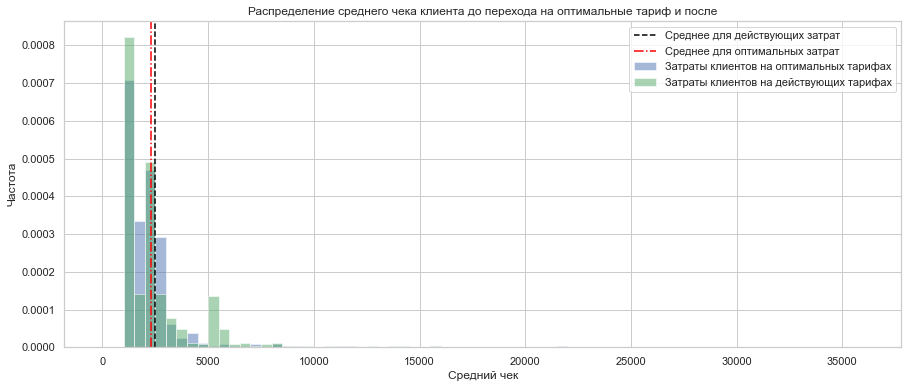

In [103]:
# посмотрим на распределение данных и на средние значения:
bin_size = 500
fig, ax = plt.subplots(figsize=(15, 6))
bin_max = max(income_optimized['total'].max(), income_fact['total'].max())

ax = (income_optimized['total']
      .hist(bins = np.arange(0, bin_max, bin_size), color='b', label='Затраты клиентов на оптимальных тарифах', alpha = 0.5, density=True)
     )
ax = (income_fact['total']
      .hist(bins = np.arange(0, bin_max, bin_size), color='g', label='Затраты клиентов на действующих тарифах', alpha = 0.5, density=True)
     )

ax.set_ylabel('Частота') 
ax.set_xlabel('Средний чек')

plt.axvline(income_fact['total'].mean(), 
            color = 'black', linestyle="--", label='Среднее для действующих затрат')
plt.axvline(income_optimized['total'].mean(), 
            color = 'red', linestyle="-.", label='Среднее для оптимальных затрат')

plt.title('Распределение среднего чека клиента до перехода на оптимальные тариф и после')
plt.legend()
plt.show()

Как мы видим средние чеки достаточно близки, при этом есть выбросы - аномалии. Данные распределены ненормально - скошены в правую область гистограммы (в область высоких значений).

In [104]:
# посмотрим на статистику:
display(income_fact['total'].describe())
display(income_optimized['total'].describe())

count      487.000000
mean      2498.566735
std       2457.247376
min       1000.000000
25%       1200.000000
50%       2000.000000
75%       2612.500000
max      36498.000000
Name: total, dtype: float64

count      487.000000
mean      2294.305955
std       2265.385847
min       1100.000000
25%       1334.500000
50%       1917.000000
75%       2452.000000
max      36498.000000
Name: total, dtype: float64

In [105]:
st.levene(income_fact['total'], 
          income_optimized['total'], center='mean')

LeveneResult(statistic=10.786606990378345, pvalue=0.0010588730259319169)

Дисперсии различаются, значит будем использовать `equal_var = False`

In [106]:
results = st.ttest_ind(income_fact['total'], income_optimized['total'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Cредние чеки клиентдо и после оптимизации потерь различаются')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    print('Cредние чеки клиентов до и после оптимизации потерь равны')
    print()

p-значение: 0.1777427764233685
Не получилось отвергнуть нулевую гипотезу
Cредние чеки клиентов до и после оптимизации потерь равны



Посмотрим на U критерий Mann-Whitney, учитывая, что в данных есть выбросы:

In [107]:
from scipy.stats import mannwhitneyu
results = mannwhitneyu(income_fact['total'], income_optimized['total'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Cредние чеки клиентдо и после оптимизации потерь различаются')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    print('Cредние чеки клиентов до и после оптимизации потерь равны')
    print()

p-значение: 0.006055001784872843
Отвергаем нулевую гипотезу
Cредние чеки клиентдо и после оптимизации потерь различаются



Получаем уже другие результаты. Отфильтруем выбросы по 99 перцентилю и проверим результат t-test.

In [108]:
limit_a = np.percentile(income_fact['total'], 99)
limit_b = np.percentile(income_optimized['total'], 99)

results = st.ttest_ind(income_fact.query('total < @limit_a')['total'], 
                       income_optimized.query('total < @limit_b')['total'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Cредние чеки клиента до и после оптимизации потерь различаются')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    print('Cредние чеки клиентов до и после оптимизации потерь равны')
    print()

p-значение: 0.014005843508519867
Отвергаем нулевую гипотезу
Cредние чеки клиента до и после оптимизации потерь различаются



В результате проверки гипотезы о различии средних чеков до и после оптимизации потерь, тест показал различия в среднем чеке. Проверим как изменился чек

In [109]:
income_fact['total'].describe()


count      487.000000
mean      2498.566735
std       2457.247376
min       1000.000000
25%       1200.000000
50%       2000.000000
75%       2612.500000
max      36498.000000
Name: total, dtype: float64

In [110]:
income_optimized['total'].describe()

count      487.000000
mean      2294.305955
std       2265.385847
min       1100.000000
25%       1334.500000
50%       1917.000000
75%       2452.000000
max      36498.000000
Name: total, dtype: float64

После оптимизации потерь средний чек клиента уменьшился

## Вывод

Проведенный анализ показал, что большинство клиентов "Нупозвони" привлекают до 5 операторов. Из активных 256 клиентов 54% подключены на тариф С, а на тариф А только 11%. 63 работают только на входящие вызовы. Средняя продолжительность вызовов, совершенных операторами за день отличается в зависимости от тарифа. Для тарифов А и В характерны более продолжительные вызовы, а для тарифа А короткие звонки и от 1 до 3 операторов.
Не смотря на разницу в использовании услуг, все три тарифа приносят одинаковый доход. Чаще переплачивают клиенты тарифа В в сумме около 1000 руб. в месяц. Клиенты тарифа А переплачивают реже, но сумма переплаты достигает 3000 руб. Тариф С остается выгодным практически для всех действующих абонентов. В случае перехода клиентов на более выгодные тарифы выручка снизится на 28,5%, а тариф А останется оптимальным только для одного клиента. Перевод клиентов на более выгодный тариф позволяет снизить средний чек клиентов, а оптимизация потерь незначительным увеличением абонентской платы позволяет снизить потери до 8,9%.